In [1]:
import numpy as np

##################################################
##### Matplotlib boilerplate for consistency #####
##################################################
from ipywidgets import interact
from ipywidgets import FloatSlider, IntSlider
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

global_fig_width = 10
global_fig_height = global_fig_width / 1.61803399
font_size = 14

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = '0.8'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlepad'] = 16.0
plt.rcParams['axes.titlesize'] = font_size * 1.4
plt.rcParams['figure.figsize'] = (global_fig_width, global_fig_height)
plt.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = font_size
plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.dashed_pattern'] = [1, 4]
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.major.pad'] = 4
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['ytick.major.pad'] = 4
plt.rcParams['ytick.major.size'] = 0
##################################################

# Course Structure

- Lecture 1: Introduction to Bayesian Inference and Pints
- Lecture 2: Maximum Likelihood Estimation
- Lecture 3: MCMC sampling
- **Lecture 4: Hierarchical models**
    - **Conditional probability distributions**
    - **Gibbs sampling**
    - **Hierarchical model - lake example**
    - **Implementation in PINTS**

## Conditional distributions

### Example Two-dimensional distribution:
- Imagine you are interested in the interrelation between the circumference of a person’s head ($H$) and the volume of their brain ($B$).
- Based on data we find there is a positive correlation between these two variables, which we represent in a distribution $P(H, B)$.

![](fig/Human-brain.SVG)

In [2]:
from scipy.stats import multivariate_normal

def brain_pdf(xy):
    return multivariate_normal.pdf(xy, mean=[45, 1500], cov=[[10**2, 5*100],[5*100,200**2]])

def get_full_brain_pdf():
    x = np.linspace(20, 70, 50)
    y = np.linspace(1000, 2000, 40)

    X, Y = np.meshgrid(x, y)
    XY = np.column_stack([X.flat, Y.flat])

    Z = brain_pdf(XY).reshape(X.shape)
    
    return X, Y, Z

def get_conditional_brain_pdf():
    x = np.linspace(20, 70, 50)
    y = 1450*np.ones_like(x)
    
    xy = np.column_stack([x, y])
    z = brain_pdf(xy).reshape(x.shape)
    
    return x, y, z

def show_brain_distribution(conditional=False):
    X, Y, Z = get_full_brain_pdf()
    plt.contourf(X, Y, Z, 20, cmap='RdGy');
    
    if conditional:
        plt.plot([20,70],[1450, 1450])
    plt.xlabel(r'$H$')
    plt.ylabel(r'$B$')
    plt.colorbar()
    
def show_brain_distribution_conditional():   
    X, Y, Z = get_full_brain_pdf()
    x, y, z = get_conditional_brain_pdf()
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))

    ax1.contourf(X, Y, Z, 20, cmap='RdGy');
    ax1.plot([20,70],[1450, 1450])
    ax2.plot(x, z)
    ax2.fill_between(x,z,alpha=0.2)
    ax1.set_xlabel(r'$H$')
    ax1.set_ylabel(r'$B$')
    ax2.set_ylabel(r'$P(B = 1450, H)$')
    ax2.set_xlabel(r'$H$')
    plt.tight_layout()


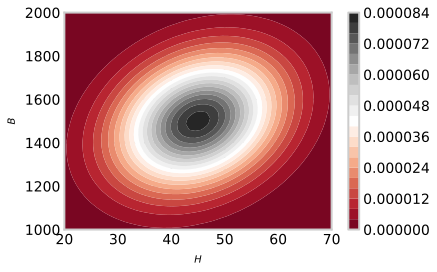

In [3]:
show_brain_distribution()

## Conditional distributions

- **Question:** If an individual has a brain volume of $1450\text{cm}^3$, then what does the distribution for their head circumference look like?
- **Answer:** Use law of conditional probability:

$$P(H|B = 1450) = \frac{P(B = 1450, H)} {P(B = 1450)}$$

- **Analogy:** imagine walking over the probability distribution along a line of $B = 1450\text{cm}^3$, and recording your height as you go.

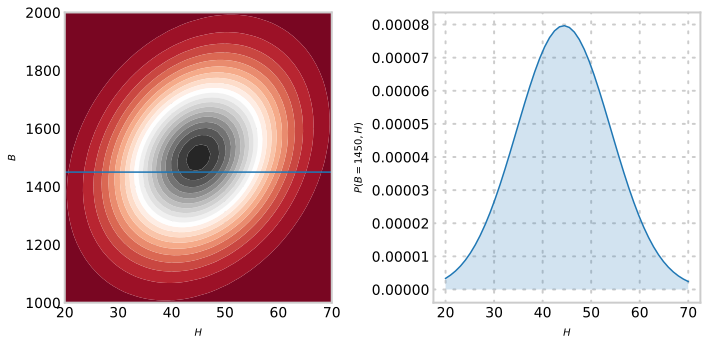

In [4]:
show_brain_distribution_conditional()

## Gibbs sampler

- A dependent sampling technique
- Useful for hierarchical models: breaks up higher-dimensional problems into separate lower-dimensional problems, *conditioned* on the remaining variables.
- Can be used in conjunction with Random Walk Metropolis method $\Rightarrow$ still allows us to use all the machinery we've already developed!
- Named after Josiah Willard Gibbs (February 11, 1839 – April 28, 1903), algorithm proposed by Stuart and Donald Geman in 1984

![](fig/Josiah_Willard_Gibbs_-from_MMS-.jpg)

## Defining the Gibbs sampler

For a parameter vector: $\boldsymbol{\theta} = (\theta_1, \theta_2, \theta_3)$:

- Select a random starting location: $(\theta_1^0, \theta_2^0, \theta_3^0)$, along the same lines as for Random Walk Metropolis.
- For each iteration $t = 1, ..., T$ do:
    1. Select a random parameter update ordering, for example $(\theta_3, \theta_2, \theta_1)$.
    2. Independently sample from the conditional posterior for each parameter in order using the most up-to-date parameters.

## Defining the Gibbs sampler

First we sample:
    
$$\theta^1_3 \sim P(\theta_3|\theta^0_2, \theta_1^0)$$

Then conditional on freshly-sampled $\theta^1_3$

$$\theta^1_2 \sim P(\theta_2|\theta^1_3, \theta_1^0)$$

Then conditional on freshly-sampled $\theta^1_3$ and $\theta_2^1$:

$$\theta^1_1 \sim P(\theta_1|\theta^1_3, \theta_2^1)$$

**Important:** in Gibbs sampling there is no rejection of steps 

$\Rightarrow$ unlike Random Walk Metropolis!



## Example application of Gibbs sampling: : speed of motion of neighbouring birds in a flock

Suppose we record the speed of bird A ($v_A$) and bird B ($v_B$) in
a flock along a particular axis.

Based on observations we find that the joint posterior
distribution over speeds is a multivariate normal distribution:


$$\begin{pmatrix} v_A \\ v_B \end{pmatrix} \sim N \left [ \begin{pmatrix} v_0 \\ v_0 \end{pmatrix}, \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \right ]$$

Of course here we have an analytic expression for the posterior distribution, but this example illustrates how the method works for more general problems.

In [5]:
def bird_pdf(xy):
    return multivariate_normal.pdf(xy, mean=[0, 0], cov=[[1, 0.5],[0.5,1]])

def get_full_bird_pdf():
    x = np.linspace(-5, 5, 50)
    y = np.linspace(-5,5, 40)

    X, Y = np.meshgrid(x, y)
    XY = np.column_stack([X.flat, Y.flat])

    Z = bird_pdf(XY).reshape(X.shape)
    
    return X, Y, Z

def show_bird_distribution():
    X, Y, Z = get_full_bird_pdf()
    plt.contourf(X, Y, Z, 20, cmap='RdGy');
    plt.xticks([0],['v_0'])
    plt.yticks([0],['v_0'])
    plt.xlabel('speed of bird A')
    plt.ylabel('speed of bird B')
    plt.colorbar()

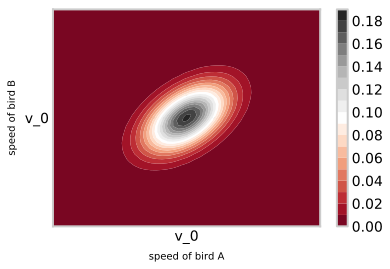

In [6]:
show_bird_distribution()

## Finding the conditional distributions

- In many circumstances we cannot find the conditional distributions however here it is possible.

- If we knew $v_B$ :

$$v_A \sim N(v_0 + \rho(v_B − v_0), 1 − \rho^2)$$

- Alternatively, if we knew $v_A$:

$$v_B \sim N(v_0 + \rho(v_A − v_0), 1 − \rho^2)$$

Use Gibbs sampling to conditionally sample: $v_A|v_B$ then $v_B |v_A$.

In [7]:
def gibbs_sample(n):
    v0 = 0
    rho = 0.5
    samples = np.empty((2,n),dtype=float)
    for i in range(n):
        # sample from v_A
        samples[0,i] = np.random.normal(v0 + rho * (samples[1,i-1] - v0), 1 - rho**2)
        
        # sample from v_B
        samples[1,i] = np.random.normal(v0 + rho * (samples[0,i] - v0), 1 - rho**2)
    return samples


In [8]:
def show_gibbs_sampling(n):
    samples = gibbs_sample(n)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8/1.618))
    X, Y, Z = get_full_bird_pdf()
    ax1.contourf(X, Y, Z, 20, cmap='RdGy');
    ax1.scatter(samples[0,:],samples[1,:],alpha=0.6)
    ax1.set_xticks([0],['v_0'])
    ax1.set_yticks([0],['v_0'])
    ax1.set_xlabel('speed of bird A')
    ax1.set_ylabel('speed of bird B')
    
    ax2.hist2d(samples[0,:],samples[1,:],bins=30)

In [9]:
interact(show_gibbs_sampling, n= IntSlider(value=10, min=0, max=6000, step=100, continuous_update=False));

interactive(children=(IntSlider(value=10, continuous_update=False, description='n', max=6000, step=100), Outpu…

## Hierarchical Models

- So far we have looked at time-series statistical models of the form:
    
$$z_i \sim y(\theta, t_i) + N(0, \sigma)$$

where $y(\theta, t)$ is the solution of a differential equation subject to a set of parameters $\theta$

- but what if some (or all) of the parameters $\theta$ were themselves drawn from a random distribution?
    
$$\theta \sim N(0, \sigma_\theta)$$

- This type of multi-level statistical model is a *hierarchical model*


## Hierarchical Models: An example

- Imagine a set of $n$ lakes, each with its own population of algae. 
- You know from measurements $z^j_i$ that the algae concentration in lake $j$ is given by:
    
$$ \frac{dy_j(t)}{dt} = r y_j(t) \frac{k_j - y_j(t)}{k_j}$$
$$z_i^j \sim y_j(t_i) + N(0,\sigma)$$

where $k_j$ is the carrying capacity of each lake, and $r$ is the growth rate

![](fig/lake.svg)

- You know that the growth rate $r$ is species dependent and therefore fixed. 
- But the carrying capacity $k_j$ varies according to the properties of each lake, and can be modelled by a Gaussian distribution

$$ k_j \sim N(k, \sigma_k)$$

![](fig/lake.svg)


$$ \frac{dy_j(t)}{dt} = r y_j(t) \frac{k_j - y_j(t)}{k_j}$$

$$z_i^j \sim y_j(t_i) + N(0,\sigma)$$

$$ k_j \sim N(k, \sigma_k)$$

- The parameters $\theta = [k_1, k_2, k_3, ..., k_n, r]$ are the parameters of our lower-level ODE model
- The parameters $\theta_h = [k, \sigma_k]$ are the *hyper-parameters* of our model
- We want to find our posterior over *all* of the parameters and hyper-parameters

![](fig/lake.svg)

## Hierarchical Models: hyper priors

- $[k, \sigma_k]$ are parameters, so in a Bayesian context we need to assign them **priors**!
- Priors for the hyper-parameters are $P(k, \sigma_k)$, we will set this to be a *normal-inverse-gamma* distribution:

$$P(k, \sigma_k) = \text{NIG}(\mu, \lambda, \alpha, \beta)$$

- Why? the normal inverse gamma distribution is *conjugate* with the Gaussian distribution. This makes it easier to calculate the posterior, more on this later...

**Question:** what is the numerator of Bayes’ rule for this problem?

**Answer:** the joint distribution of the data X and parameters; i.e. $P(X, \theta, \theta_h, \mu, \lambda, \alpha, \beta)$

**Another question:** how do we find this here? 

**Another answer:** exploit conditional independence of the problem!

## Graphical model

Start with hyper-parameters, the "population" level parameters

![](fig/hierachical1.svg)


## Graphical model

And determine their joint probability.

![](fig/hierachical2.svg)

## Graphical model

Find the probability of $\theta$ **conditional** on $k$ and $\sigma_k$.

![](fig/hierachical3.svg)

## Graphical model

and then the probability of the data $X$ conditional on $\theta$.

![](fig/hierachical4.svg)

## Graphical model

Finally to obtain the overall probability, multiply together all these terms

![](fig/hierachical6.svg)


So the posterior is found as: 
    
\begin{align*}
P(\theta, k, \sigma_k | X) &\propto P(X, \theta, k, \sigma_k) \\
& = \color{red}{P(X | \theta)} \times \color{blue}{P(\theta | k, \sigma_k)} \times \color{purple}{P(k, \sigma_k)}
\end{align*}

- $\color{red}{P(X|\theta)}$ is just the **likelihood**.
- $\color{blue}{P(\theta|k, \sigma_k)}$ is the **prior** on $\theta$.
- $\color{purple}{P(k, \sigma_k)}$ is the **hyper-prior** on the hyper-parameters $k$ and $\sigma_k$.
- However the word “hyper” is really just a fancy word we use to represent priors on “population” level parameters.
- In hierarchical models there is a blurring of the likelihood/prior boundary.

## Graphical model

Our likelihood and prior are really many models, one for each lake or output value

![](fig/hierachical5.svg)

- All these models at the same level of the hierarchy are independent, so out posterior now becomes

\begin{align*}
P(\theta, k, \sigma_k | X) &\propto P(X, \theta, k, \sigma_k) \\
& = \color{red}{P(X | \theta)} \times \color{blue}{P(\theta | k, \sigma_k)} \times \color{purple}{P(k, \sigma_k)} \\
& = \color{red}{\prod_i^N P(X_i | \theta)} \times \color{blue}{P(r) \prod_i^n P(k_i | k, \sigma_k)} \times \color{purple}{P(k, \sigma_k)}
\end{align*}


**Next problem:** how do we calculate this? How do we sample from this?

## Answer: Gibbs sampling

- our posterior is:

\begin{align*}
P(\theta, k, \sigma_k | X) &\propto \prod_i^N P(X_i | \theta) \times P(r) \prod_i^n P(k_i | k, \sigma_k) \times P(k, \sigma_k)
\end{align*}

- We can use Gibbs sampling, combined with MCMC, to sample from this
- First we write down the posterior conditioned on each of our parameters

## Conditional distributions

1. Posterior distribution conditioned on $k$ and $\sigma_k$

\begin{align*}
P(\theta | k, \sigma_k, X) &\propto \prod_i^N P(X_i | \theta) \times P(r) \prod_i^n P(k_i | k, \sigma_k) \times P(k, \sigma_k) \\
&\propto \prod_i^N P(X_i | \theta) \times P(r) \prod_i^n P(k_i | k, \sigma_k)
\end{align*}

2. Posterior distribution conditioned on $\theta$

\begin{align*}
P(k, \sigma_k | \theta, X) &\propto \prod_i^N P(X_i | \theta) \times P(r) \prod_i^n P(k_i | k, \sigma_k) \times P(k, \sigma_k) \\
&\propto \prod_i^n P(k_i | k, \sigma_k) \times P(k, \sigma_k)
\end{align*}

**Question:** Can sample from 1. using MCMC as before. Could do the same for 2., but we can do better...how?


**Answer**: Make sure we are using a combination of likelihood and prior that are *conjugate* with each other

- If the posterior and prior are the same distribution for a particular likelihood function, then the prior distribution is called a *conjugate prior* for that likelihood.
- Another way to sample from the posterior (as long as you can sample from the prior)
- **For example:** the normal-inverse-gamma distribution is a conjugate prior for the Gaussian distribution (See table [here](https://en.wikipedia.org/wiki/Conjugate_prior)), so

\begin{align*}
P(k, \sigma_k | \theta, X) &\propto \prod_i^n P(k_i | k, \sigma_k) \times P(k, \sigma_k) \\
 &\propto \prod_i^n \text{N}(k_i, \sigma_k) \times \text{NIG}(\mu, \lambda, \alpha, \beta) \\
 &\propto \text{NIG}\left (\frac{\lambda \mu + n \overline{k}}{\lambda + n}, \lambda + n, \alpha + \frac{n}{2}, \beta + \frac{1}{2}\sum_{i=1}^N (k_i - \overline{k})^2 + \frac{n\lambda}{\lambda+n}\frac{(\overline{k} - \mu)^2}{2} \right)
\end{align*}

where $\overline{k} = \frac{1}{n} \sum_{i=1}^n k_i$


## Implementation in PINTS

- now we have all the equations in place to start sampling from this posterior
- the next slides will go through how to implement this in PINTS


## Generate data

- we will use the `LogisticModel` from PINTs.
- we need to set the real parameters, and then generate some data 

In [10]:
import pints
import pints.toy
model = pints.toy.LogisticModel()

n = 10
noise = 20
real_hyper_parameters = [500, 50]
real_parameters = [
    np.array([0.015, np.random.normal(real_hyper_parameters[0], real_hyper_parameters[1])]) 
        for i in range(n)
]
times = np.linspace(0, 800, 50)
values = [
    model.simulate(real, times) + np.random.normal(0, noise, times.shape)
        for real in real_parameters
]

## Likelihoods $P(X | \theta)$

- need to create one for each lake
- we will assume the measurement noise is known for each likelihood

In [11]:
problems = [
    pints.SingleOutputProblem(model, times, v)
        for v in values
]

log_likelihoods = [
    pints.GaussianKnownSigmaLogLikelihood(problem, noise)
        for problem in problems
]

## Priors $P(\theta|k, \sigma_k)$

- Uniform prior for $r$ over a sensible range
- Gaussian prior for $k_i$. The mean & standard deviation will be conditioned later during the Gibbs sampling, but we will set initial values here

In [12]:
log_priors = [
    pints.ComposedLogPrior(
        pints.UniformLogPrior([0.01],[0.02]),
        pints.GaussianLogPrior(real_hyper_parameters[0],1e9*real_hyper_parameters[0])
    )
        for i in range(n)
]

## MCMC samplers

- We will use random initial points for the MCMC samplers
- Using Adaptive Covariance MCMC method

In [13]:
log_posteriors = [
    pints.LogPosterior(log_likelihood, log_prior)
        for log_likelihood, log_prior in zip(log_likelihoods,log_priors)
]

starting_points = [
    [ real*np.random.uniform(0.9,1.1) ]
    for real in real_parameters
]

samplers = [
    pints.AdaptiveCovarianceMCMC(x0)
     for x0 in starting_points
]

## Initial phase for MCMC samplers

- We will use the *ask-and-tell* interface for the MCMC samplers during Gibbs
- Therefore, need to manually run the initial phase for each MCMC sampler (normally done automatically)

In [14]:
n_burn_in = 200
[sampler.set_initial_phase(True) for sampler in samplers]
for sample in range(n_burn_in):
    for i, (sampler, log_posterior) in enumerate(zip(samplers, log_posteriors)):
        x = sampler.ask()
        sampler.tell(log_posterior(x))
[sampler.set_initial_phase(False) for sampler in samplers];

## Conditional sampler 1.

This function samples from the posterior distribution conditioned on $k$ and $\sigma_k$

In [15]:
def conditional_sampler1(samplers, log_posteriors):
    xs = np.empty((2, n))
    error = 0
    for i, (sampler, log_posterior) in enumerate(zip(samplers, log_posteriors)):
        x = sampler.ask()
        xs[:,i] = sampler.tell(log_posterior(x))
    return xs

## Conditional sampler 2.

This function samples from the posterior distribution conditioned on $\theta$

In [16]:
import sys
import scipy.stats
def conditional_sampler2(xs, mu_0, k_0, alpha_0, beta_0):
    xhat = np.mean(xs[1,:])
    var = np.sum((xs[1,:]-xhat)**2)

    k = k_0 + n
    mu = (k_0 * mu_0 + n * xhat) / float(k)
    alpha = alpha_0 + n/2
    beta = beta_0 + 0.5*(var + ((k_0 * n) / k) * (xhat - mu_0)**2)
    
    variance_sample = scipy.stats.invgamma.rvs(a=alpha, loc=0, scale=beta)
    mean_sample = scipy.stats.norm.rvs(mu,np.sqrt(variance_sample / k))
    
    return mean_sample, variance_sample

## Gibbs sampler

Now we will put them all togeter and run our Gibbs sampler.

First set the parameters for the hyper-prior and allocate space for the chains

In [17]:
# prior hyperparameters
k_0 = 0
mu_0 = 0
alpha_0 = 0
beta_0 = 0

samples = 5000
chain = np.empty((samples, 2))
k_chains = [np.empty((samples, 2)) for i in range(n)]

## Gibbs sampler

... then perform the sampling

In [18]:
for sample in range(samples):
    # sample from the posterior distribution conditioned on $k$ and $\sigma_k$
    xs = conditional_sampler1(samplers, log_posteriors)
    
    # sample from the posterior distribution conditioned on $\theta$
    mean_sample, variance_sample = conditional_sampler2(xs, mu_0, k_0, alpha_0, beta_0)

    # store samples
    for i in range(n):
        k_chains[i][sample, :] = xs[:, i]
    chain[sample, 0] = mean_sample
    chain[sample, 1] = np.sqrt(variance_sample)

    # update mcmc sampler's priors with samples of the prior parameters,
    for i, (log_posterior, sampler) in enumerate(zip(log_posteriors, samplers)):
        log_posterior._log_prior._priors[1].__init__(mean_sample,np.sqrt(variance_sample))

# Samples of hyper-parameters $k$ and $\sigma_k$

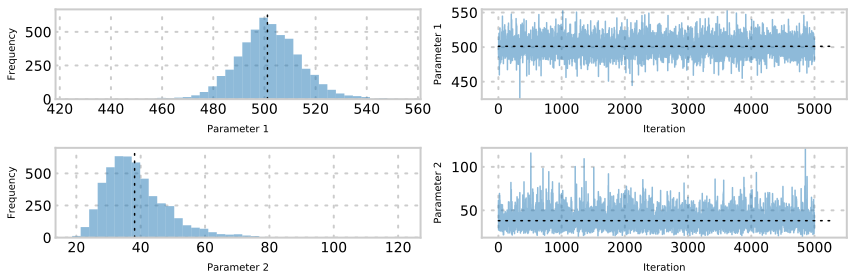

In [19]:
import pints.plot
ks = [real[1] for real in real_parameters]
pints.plot.trace([chain],ref_parameters=[np.mean(ks),np.std(ks)]);

## Samples of parameters $k_i$

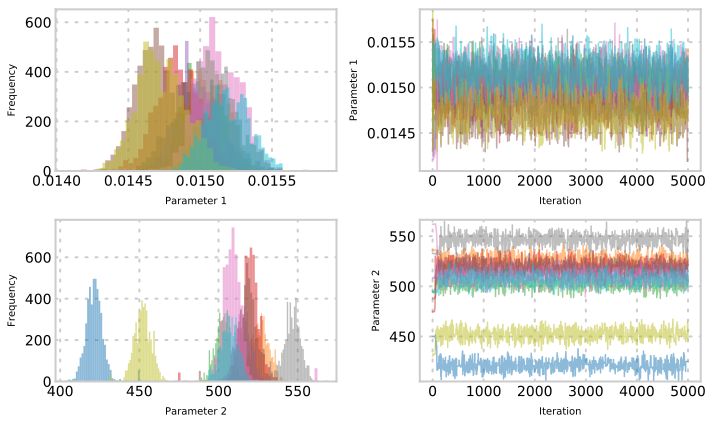

In [20]:
fig, axes = pints.plot.trace(k_chains)
axes[0, 0].get_legend().remove()
fig.set_size_inches(10,6)
fig.tight_layout()
plt.show()

## Summary

- Gibbs sampling is a way of breaking up a high-dimensional problem into more managable sub-problems by conditioning on the other parameters
- Hierachical problems arise by considering generating models for parameters
- Sampling from hierachical models is often problem specific, but can (in certain cases) be automated (see probabilistic programming)
- PINTS can sample from hiearachical models using the ask-and-tell interface